# Machine Learning - TP1

Eloy Zerbatto Diaz

## Exploración de los datos

In [139]:
import pandas as pd 
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
RANDOM_STATE = 0


In [2]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')

Se visualizan las primeras filas de la tabla, observandose datos numéricos, categoricos y alfanuméricos.

In [36]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_id
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,3
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,3
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,4
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,3


Se visualiza la cantidad de transacciones en la duración de la prueba

Cantidad de datos: 6362620
La cantidad de horas registradas fue 743


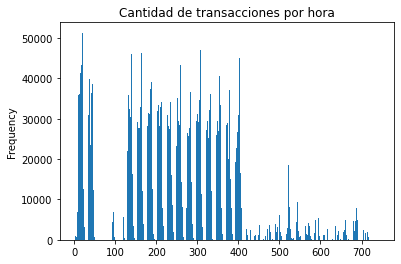

In [9]:
print('Cantidad de datos: {}'.format(len(data)))
registro_horas = data['step'].to_numpy()[-1]
print('La cantidad de horas registradas fue {}'.format(registro_horas))

ax = data['step'].plot.hist(bins=registro_horas,title = 'Cantidad de transacciones por hora')


Se reemplaza la variable "type" por "type_id", la cual representa de forma numérica a la primera.

In [37]:
types = list(set(data['type']))
type_dict={}

for i, t in enumerate(types):
    type_dict[t] = i

data['type_id'] = [type_dict[t] for t in  data['type'] ]

In [38]:
num_data = data[['step','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']]

num_data.head()

,step,type_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,1,181.00,181.0,0.00,0.0,0.0,1
3,1,4,181.00,181.0,0.00,21182.0,0.0,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


Se genera la columna "day_moment", la cual indica "la hora del día en la que se huzo la transacción"

In [39]:
day_moment = np.array((num_data['step']/24 - (num_data['step']/24).astype(int))*24,int)
num_data['day_moment'] = day_moment


C:\Users\zerba\AppData\Local\Temp\ipykernel_11788\157635755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_data['day_moment'] = day_moment


In [40]:
num_data.head(150)

,step,type_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,day_moment
0,1,3,9839.64,170136.00,160296.36,0.00,0.00,0,1
1,1,3,1864.28,21249.00,19384.72,0.00,0.00,0,1
2,1,1,181.00,181.00,0.00,0.00,0.00,1,1
3,1,4,181.00,181.00,0.00,21182.00,0.00,1,1
4,1,3,11668.14,41554.00,29885.86,0.00,0.00,0,1
...,...,...,...,...,...,...,...,...,...
145,1,3,3026.98,31139.00,28112.02,0.00,0.00,0,1
146,1,4,467177.03,28112.02,0.00,975121.00,22190.99,0,1
147,1,0,3875.99,259138.00,255262.01,608925.82,2415.16,0,1
148,1,3,2148.89,31213.00,29064.11,0.00,0.00,0,1


Se observa la frecuencia de ocurrencia de las transacciones fraudulentas dirante el transcurso del día.

<BarContainer object of 24 artists>

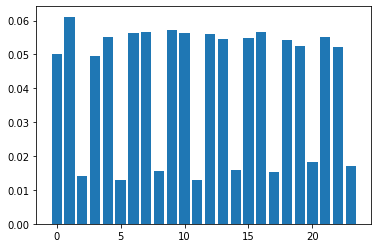

In [42]:
sum_fraud_per_h = []
for h in list(set(num_data['day_moment'])):
    a = num_data[num_data['day_moment'] == h]
    sum_fraud_per_h.append(a['isFraud'].sum())

sum_fraud_per_h = np.array(sum_fraud_per_h)
plt.figure()
plt.bar(range(0,24),sum_fraud_per_h/np.sum(sum_fraud_per_h))
plt.title('Distribucion de la muestra')


## Balanceo de las muestras

Se procede a quitar datos de la categoria mayoritaria hasta igualar la cantidad a los de la clase minoritaria

In [44]:
num_data_isFraud_True = num_data[num_data['isFraud'] == True]
num_data_isFraud_False = num_data[num_data['isFraud'] == False]
num_data_isFraud_False_sample = num_data_isFraud_False.sample(frac=len(num_data_isFraud_True)/len(num_data_isFraud_False), random_state=RANDOM_STATE)
num_data_downsampled = pd.concat([num_data_isFraud_True, num_data_isFraud_False_sample], ignore_index=True)
num_data_downsampled.head()

,step,type_id,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,day_moment
0,1,1,181.0,181.0,0.0,0.0,0.0,1,1
1,1,4,181.0,181.0,0.0,21182.0,0.0,1,1
2,1,1,2806.0,2806.0,0.0,0.0,0.0,1,1
3,1,4,2806.0,2806.0,0.0,26202.0,0.0,1,1
4,1,1,20128.0,20128.0,0.0,0.0,0.0,1,1


Se arman los sets de train y test, balanceando la cantidad de categorias en cada dataset en base a la valirable isFroud

In [45]:
train, test = train_test_split(num_data_downsampled, stratify= num_data_downsampled['isFraud'], shuffle = True)


Se verofican las diemnsiones y el porcentaje de isFraud = True en cada dataset

In [47]:
isFraud_train_per = train['isFraud'].sum()/train['isFraud'].count()
print('Del total de datos de train = {}, el {:.2f}% corresopnde a isFraud = True'.format(train['isFraud'].count(),isFraud_train_per*100))

isFraud_test_per = test['isFraud'].sum()/test['isFraud'].count()
print('Del total de datos de train = {}, el {:.2f}%  corresopnde a isFraud = True'.format(test['isFraud'].count(),isFraud_test_per*100))

Del total de datos de train = 12319, el 50.00% corresopnde a isFraud = True
Del total de datos de train = 4107, el 49.99%  corresopnde a isFraud = True


## LogisticRegression

En primer lugar se utilizan las variables numericas originales del dataset.

In [56]:
x_train = train[['step','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y_train = train['isFraud']

x_test = test[['step','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y_test = test['isFraud']

CASO 1

Se entrena un modelo de LogisticRegression, ponderando las clases basada en la frecuencia dentro de set de train

<Figure size 432x288 with 0 Axes>

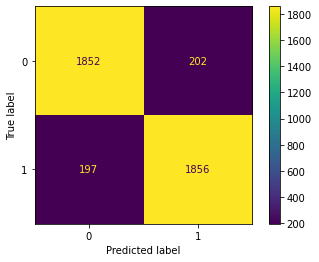

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2054
           1       0.90      0.90      0.90      2053

    accuracy                           0.90      4107
   macro avg       0.90      0.90      0.90      4107
weighted avg       0.90      0.90      0.90      4107



In [88]:
LR = LogisticRegression( solver = 'lbfgs',penalty= 'none',class_weight='balanced', random_state= RANDOM_STATE)
LR.fit(x_train,y_train)
pred = LR.predict(x_test)
plt.figure()
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, pred))


CASO 2

Repetimos el proceso pero reemplazando la variable 'step' por 'day_moment'


In [89]:
x_train = train[['day_moment','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y_train = train['isFraud']

x_test = test[['day_moment','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y_test = test['isFraud']

<Figure size 432x288 with 0 Axes>

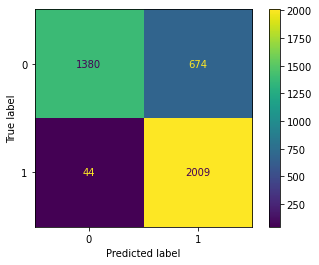

              precision    recall  f1-score   support

           0       0.97      0.67      0.79      2054
           1       0.75      0.98      0.85      2053

    accuracy                           0.83      4107
   macro avg       0.86      0.83      0.82      4107
weighted avg       0.86      0.83      0.82      4107



In [94]:
LR = LogisticRegression( solver = 'lbfgs',penalty= 'none',class_weight='balanced', random_state= RANDOM_STATE)
LR.fit(x_train,y_train)
pred = LR.predict(x_test)
plt.figure()
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, pred))

CASO 3

Repetimos el proceso con ambas variables 'step' y 'day_moment'

<Figure size 432x288 with 0 Axes>

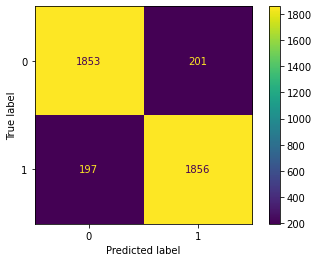

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2054
           1       0.90      0.90      0.90      2053

    accuracy                           0.90      4107
   macro avg       0.90      0.90      0.90      4107
weighted avg       0.90      0.90      0.90      4107



In [105]:
x_train = train[['step','day_moment','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y_train = train['isFraud']

x_test = test[['step','day_moment','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y_test = test['isFraud']

LR = LogisticRegression( solver = 'lbfgs',penalty= 'none',class_weight='balanced', random_state= RANDOM_STATE)
LR.fit(x_train,y_train)
pred = LR.predict(x_test)
plt.figure()
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, pred))


### Observaciones 
Se observa que si bien en el caso 1 el accuracy es superior, En el caso 2 el recall para los casos positivos se logra un 98%. Para el caso 3, se obtienen los mismos resultados que para el caso 1, con la variable 'step'.
El recall mide en este caso la cantidad de casos positivos detectados sobre el total de positivos reales. Para este problema deseamos maximizar la detección de los casos de Fraude, es por eso que se opta por el modelo del caso 2.

## SVM
Se utilizaran los datos con el agregado de la variable 'day_moment y sin 'step'.

In [106]:
x_train = train[['day_moment','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y_train = train['isFraud']

x_test = test[['day_moment','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y_test = test['isFraud']

In [107]:
clf = SVC(random_state=RANDOM_STATE, class_weight='balanced')
clf.fit(x_train, y_train)

SVC(class_weight='balanced', random_state=0)

<Figure size 432x288 with 0 Axes>

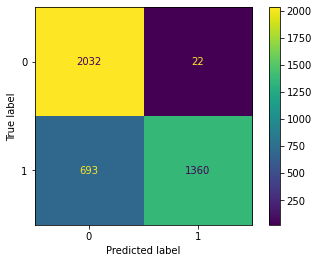

              precision    recall  f1-score   support

           0       0.75      0.99      0.85      2054
           1       0.98      0.66      0.79      2053

    accuracy                           0.83      4107
   macro avg       0.86      0.83      0.82      4107
weighted avg       0.86      0.83      0.82      4107



In [108]:
pred = clf.predict(x_test)
plt.figure()
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, pred))

# Random Forest

In [188]:
x_train = train[['day_moment','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y_train = train['isFraud']

x_test = test[['day_moment','type_id','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y_test = test['isFraud']

Se entrena un modelo de Random Forest con el numero de estimadores por defecto = 100

<Figure size 432x288 with 0 Axes>

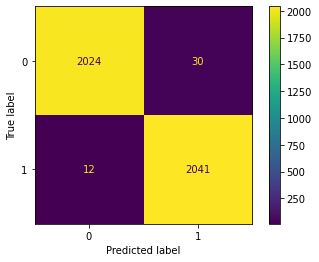

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2054
           1       0.99      0.99      0.99      2053

    accuracy                           0.99      4107
   macro avg       0.99      0.99      0.99      4107
weighted avg       0.99      0.99      0.99      4107

0.9941548952752071


In [189]:
clf = RandomForestClassifier(n_estimators = 100,random_state=RANDOM_STATE)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
plt.figure()
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, pred))
recall_100 = recall_score(y_test, pred, average=None)[1]
print(recall_100)

Se observa que el recall llega al 100%
Se procede a busar el numero minimo de estimadores que iguale la el mejor recall obtenido con este modelo

n_estimators: 7


<Figure size 432x288 with 0 Axes>

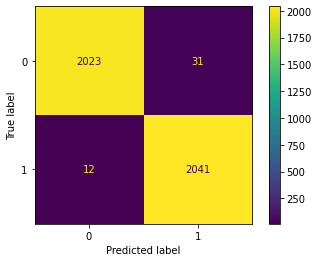

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2054
           1       0.99      0.99      0.99      2053

    accuracy                           0.99      4107
   macro avg       0.99      0.99      0.99      4107
weighted avg       0.99      0.99      0.99      4107



In [190]:
recall_pos = 0
best_recall = recall_100
for n in range(1,100):
    clf = RandomForestClassifier(n_estimators = n,random_state=RANDOM_STATE)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    current_recall = recall_score(y_test, pred, average=None)[1]
    if current_recall > recall_pos:
        recall_pos = recall_score(y_test, pred, average=None)[1]
        n_estimators = n
    
    if recall_pos >= best_recall:
        break

print('n_estimators:', n_estimators)
clf = RandomForestClassifier(n_estimators = n_estimators,random_state=RANDOM_STATE)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
plt.figure()
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, pred))

## Conclusiones

Se evaluaron tres modelos clasificadores (LogisticRegression, SVM y RandomForest). 
Se estudió el impacto de la cantidad y tipo de features en cada uno de los casos. Se dejan registrados los casos mas relevantes.

El modelo de RandomForest mostró mejores metricas en general, siendo la determinante para este caso el recall, que indicará la capacidad de detectar fraude entre todas las transacciones fraudulentas reales.

Con una aproximación inicial se entrenó un modelo de RandomForest con n_componentes = 100 y se obtuvo un recall de 0.9961. Tomando este valor como referencia se intento reducir la cantidad de n_componentes hasta igualar el resultado obtenido ara 100. 
* Cuando se realizó el ensayo con las variables originales del dataset ( haciendo uso de la columna 'Step'), la cantidad de estimadores mínimo fue 59.
* Al utilizar como variable de entrada 'day_moment' y no 'step', la cantidad de componentes mínima necesaria se redujo a 7.

El modelo selecionado para resolver el problema es un modelo de RandomForest, entrenado con un dataset al cual se le hicieron dos modificaciones preliminares:
* Se igualó la cantidad de muestras presentes para cada una de las categorías. Se decidió downsamplear de forma aleatoria la categoria mayoritaria (isFraud = False) hasta tener un número igual a ensayos correspondientes a isFraud = True.
* Se creó una nueva variable 'day_moment'en base a la variable original 'step', la cual representa el momento del día en el que se dió determinada transacción.

Los resultados se muestran en la matriz de confusion y el reporte de métricas a continuación.

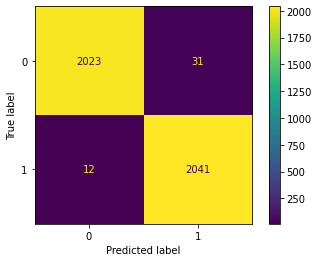

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2054
           1       0.99      0.99      0.99      2053

    accuracy                           0.99      4107
   macro avg       0.99      0.99      0.99      4107
weighted avg       0.99      0.99      0.99      4107



In [191]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, pred))